# A simple example of lensing estimator modules
This code compute normalization and power spectrum of quadratic estiamtors

In [10]:
# external
import numpy as np
from matplotlib.pyplot import *
# from cmblensplus/wrap/
import basic
import curvedsky as cs
# from cmblensplus/utils/
import plottools as pl
import binning as bn

First define parameters

In [2]:
Tcmb  = 2.726e6    # CMB temperature
Lmax  = 1024       # maximum multipole of output normalization
rlmin, rlmax = 100, 1024  # CMB multipole range for reconstruction
L = np.linspace(0,Lmax,Lmax+1)
Lfac = (L*(L+1.))**2/(2*np.pi)
nside = 1024

Load arrays of CMB unlensed and lensed Cls. Unlensed Cls are not used for now. The Cls should not be multiplied by any factors and should not have units.  

In [3]:
# lcl is an array of shape [0:4,0:rlmax+1] and lcl[0,:] = TT, lcl[1,:] = EE, lcl[2,:] = BB, and lcl[3,:] = TE
lcl = basic.aps.read_cambcls('../data/lensedcls.dat',2,rlmax,4,bb=True)/Tcmb**2 # TT, EE, BB, TE

Define observed CMB cls. Here, no CMB noise.

In [4]:
ocl = lcl # observed Cl (here, no CMB noise)

### Compute normalization

QDO below specifies which normalizations will be computed: TT, TE, EE, TB, EB, BB (currently BB is ignored even if you set True)

MV is also automatically computed from these specified estimators

In [5]:
QDO = [True,True,True,True,True,False] # this means that TT, TE, EE, TB and EB are used for MV estimator

"Wg" ("Wc") below is the optimal weight for constructing the MV estimator; $$\phi^{MV} = A^{MV}\sum_q W_q \phi^q$$ where $W$ is Wg (Wc) and $q = TT, TE, \dots$. 
BB is not output, and the array has 6 normalizations (TT, TE, EE, TB, EB and MV)

In [6]:
Ag, Ac, Wg, Wc = cs.norm_lens.qall(QDO,Lmax,rlmin,rlmax,lcl,ocl)

### Comparison with a simple simulation

Then apply diagonal C-inverse filtering (idealistic case)

In [22]:
simn = 200
cl = np.zeros((simn,2,Lmax+1))
for i in range(simn):
    print(i, end=' ')
    Talm, Ealm, Balm = cs.utils.gaussTEB(rlmax,lcl[0,:],lcl[1,:],lcl[2,:],lcl[3,:])
    Fl = np.zeros((3,rlmax+1,rlmax+1)) # the first index means 0=T, 1=E, 2=B
    for l in range(rlmin,rlmax+1):
        Fl[:,l,0:l+1] = 1./ocl[:3,l,None]
    # multiply filter to alms
    Talm *= Fl[0,:,:]
    Ealm *= Fl[1,:,:]
    Balm *= Fl[2,:,:]
    glm, clm = {}, {}
    glm['TT'], clm['TT'] = cs.rec_lens.qtt(Lmax,rlmin,rlmax,lcl[0,:],Talm,Talm,nside=nside)
    glm['TE'], clm['TE'] = cs.rec_lens.qte(Lmax,rlmin,rlmax,lcl[3,:],Talm,Ealm,nside=nside)
    glm['EE'], clm['EE'] = cs.rec_lens.qee(Lmax,rlmin,rlmax,lcl[1,:],Ealm,Ealm,nside=nside)
    glm['TB'], clm['TB'] = cs.rec_lens.qtb(Lmax,rlmin,rlmax,lcl[3,:],Talm,Balm,nside=nside)
    glm['EB'], clm['EB'] = cs.rec_lens.qeb(Lmax,rlmin,rlmax,lcl[1,:],Ealm,Balm,nside=nside)
    for qi, q in enumerate(['TT','TE','EE','TB','EB']):
        glm[q] *= Ag[qi,:,None]
        clm[q] *= Ac[qi,:,None]
    glm['MV'], clm['MV'] = 0., 0.
    for qi, q in enumerate(['TT','TE','EE','TB','EB']):
        glm['MV'] += Wg[qi,:,None]*glm[q]
        clm['MV'] += Wc[qi,:,None]*clm[q]
    glm['MV'] *= Ag[5,:,None]
    clm['MV'] *= Ac[5,:,None]
    #for q in ['TT','TE','EE','TB','EB','MV']:
    q = 'MV'
    cl[i,0,:] = cs.utils.alm2cl(Lmax,glm[q])
    cl[i,1,:] = cs.utils.alm2cl(Lmax,clm[q])
print('finish')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 finish


/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


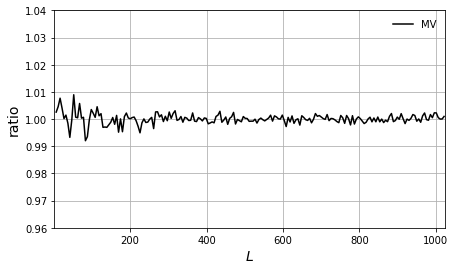

In [43]:
# plot spectra (gradient)
mb = bn.multipole_binning(200,lmin=4,lmax=Lmax)
mcl = np.mean(cl,axis=0)
mcb = bn.binning(mcl[0,:]/Ag[5,:],mb)
Ab = bn.binning(Ag[5,:],mb)
pl.plot_1dstyle(fsize=[7,4],xmin=2,xmax=Lmax,ymin=.96,ymax=1.04,grid=True,ylab=r'ratio')
for qi, (c, q) in enumerate([('k','MV')]):
    plot(mb.bc,mcb,color=c,ls='-',label=q)
legend()